<a href="https://colab.research.google.com/github/SuppaTessta/surface-defect-detection/blob/main/Surface_Defect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1 : Install Additional Dependencies for this Project

In [2]:
!pip install --upgrade ultralytics  # YOLOv8/v11
!pip install --upgrade albumentations  # Data augmentation
!pip install --upgrade roboflow  # For dataset management (optional)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 133.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


## Step 2: Upload NEU Dataset

Upload the NEU Surface Defect Database ZIP file you downloaded from Kaggle.

In [3]:
# Upload dataset
from google.colab import files
import zipfile
import os

print("Upload your NEU dataset ZIP file:")
uploaded = files.upload()

# Extract dataset
for filename in uploaded.keys():
    print(f"Extracting {filename}...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('/content/data')
    print(f"✅ Extracted to /content/data")

# Verify dataset structure
print("\n📁 Dataset structure:")
!ls -lh /content/data

Upload your NEU dataset ZIP file:


Saving Dataset.zip to Dataset.zip
Extracting Dataset.zip...
✅ Extracted to /content/data

📁 Dataset structure:
total 4.0K
drwxr-xr-x 4 root root 4.0K Oct 29 14:41 NEU-DET


## Step 3: Verify Dataset Structure

Check that all 6 defect classes are present (300 images each).

In [4]:
import os

# Check dataset structure
print("="*60)
print("Dataset Structure")
print("="*60)

base_path = '/content/data/NEU-DET'

# Check main folders
for folder in ['train', 'validation', 'sample_data']:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        print(f"\n✅ {folder}/")
        subfolders = os.listdir(folder_path)
        for subfolder in subfolders:
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                count = len(os.listdir(subfolder_path))
                print(f"   └── {subfolder}/  ({count} files)")

# Count training images
train_images = '/content/data/NEU-DET/train/images'
val_images = '/content/data/NEU-DET/validation/images'

if os.path.exists(train_images):
    train_count = len([f for f in os.listdir(train_images) if f.endswith(('.jpg', '.png', '.bmp'))])
    print(f"\n📊 Training images: {train_count}")

if os.path.exists(val_images):
    val_count = len([f for f in os.listdir(val_images) if f.endswith(('.jpg', '.png', '.bmp'))])
    print(f"📊 Validation images: {val_count}")

print("="*60)

Dataset Structure

✅ train/
   └── images/  (6 files)
   └── annotations/  (1439 files)

✅ validation/
   └── images/  (6 files)
   └── annotations/  (361 files)

📊 Training images: 0
📊 Validation images: 0


## Step 4: Analyze Annotation Format

Check what defect classes are present in the annotations.

In [5]:
import xml.etree.ElementTree as ET
import os

# Parse sample annotations to find classes
annotation_path = '/content/data/NEU-DET/train/annotations'
annotation_files = [f for f in os.listdir(annotation_path) if f.endswith('.xml')]

# Extract unique classes
classes_found = set()

print("="*60)
print("Analyzing Annotations")
print("="*60)

for i, ann_file in enumerate(annotation_files[:20]):  # Check first 20
    tree = ET.parse(os.path.join(annotation_path, ann_file))
    root = tree.getroot()

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        classes_found.add(class_name)

print(f"\n✅ Found {len(classes_found)} defect classes:")
for idx, cls in enumerate(sorted(classes_found), 1):
    print(f"  {idx}. {cls}")

# Count annotations per class
class_counts = {cls: 0 for cls in classes_found}

for ann_file in annotation_files:
    tree = ET.parse(os.path.join(annotation_path, ann_file))
    root = tree.getroot()

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name in class_counts:
            class_counts[class_name] += 1

print(f"\n📊 Defect instances in training set:")
for cls, count in sorted(class_counts.items()):
    print(f"  {cls:20s}: {count:4d} instances")

print("="*60)

# Save class list for later
classes_list = sorted(classes_found)

Analyzing Annotations

✅ Found 6 defect classes:
  1. crazing
  2. inclusion
  3. patches
  4. pitted_surface
  5. rolled-in_scale
  6. scratches

📊 Defect instances in training set:
  crazing             :  524 instances
  inclusion           :  852 instances
  patches             :  688 instances
  pitted_surface      :  345 instances
  rolled-in_scale     :  496 instances
  scratches           :  427 instances


## Step 5: Convert XML Annotations to YOLO Format

NEU-DET uses XML (Pascal VOC format). YOLOv8 needs YOLO format (.txt files).

In [10]:
import xml.etree.ElementTree as ET
import os
from pathlib import Path
import shutil
from PIL import Image

def convert_xml_to_yolo(xml_file, img_width, img_height, class_names):
    """Convert Pascal VOC XML to YOLO format"""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    yolo_annotations = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_names:
            continue

        class_id = class_names.index(class_name)

        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)

        # Convert to YOLO format (normalized center x, y, width, height)
        x_center = (xmin + xmax) / 2.0 / img_width
        y_center = (ymin + ymax) / 2.0 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_annotations

# Create YOLO dataset structure
yolo_base = '/content/yolo_dataset'
os.makedirs(f"{yolo_base}/images/train", exist_ok=True)
os.makedirs(f"{yolo_base}/images/val", exist_ok=True)
os.makedirs(f"{yolo_base}/labels/train", exist_ok=True)
os.makedirs(f"{yolo_base}/labels/val", exist_ok=True)

print("="*60)
print("Converting to YOLO Format")
print("="*60)

# Process training set
train_ann_path = '/content/data/NEU-DET/train/annotations'
train_img_base_path = '/content/data/NEU-DET/train/images'
train_annotations = [f for f in os.listdir(train_ann_path) if f.endswith('.xml')]

converted_train_count = 0
for ann_file in train_annotations:
    # Get image filename and path by searching subfolders
    img_name_without_ext = ann_file.replace('.xml', '')
    img_path = None
    for root, _, files in os.walk(train_img_base_path):
        for f in files:
            if f.startswith(img_name_without_ext) and f.lower().endswith(('.jpg', '.png', '.bmp')):
                img_path = os.path.join(root, f)
                img_name = f # Use the actual image filename
                break
        if img_path:
            break

    if not img_path:
        # print(f"Image not found for annotation {ann_file}") # Optional: print missing images
        continue

    # Get image dimensions
    try:
        with Image.open(img_path) as img:
            img_width, img_height = img.size
    except Exception as e:
        print(f"Error opening image {img_path}: {e}")
        continue


    # Convert annotation
    xml_path = os.path.join(train_ann_path, ann_file)
    yolo_lines = convert_xml_to_yolo(xml_path, img_width, img_height, classes_list)

    # Save YOLO annotation
    label_file = ann_file.replace('.xml', '.txt')
    with open(f"{yolo_base}/labels/train/{label_file}", 'w') as f:
        f.write('\n'.join(yolo_lines))

    # Copy image
    shutil.copy(img_path, f"{yolo_base}/images/train/{img_name}")
    converted_train_count += 1


print(f"✅ Converted {converted_train_count} training annotations and images")

# Process validation set
val_ann_path = '/content/data/NEU-DET/validation/annotations'
val_img_base_path = '/content/data/NEU-DET/validation/images'
val_annotations = [f for f in os.listdir(val_ann_path) if f.endswith('.xml')]

converted_val_count = 0
for ann_file in val_annotations:
    # Get image filename and path by searching subfolders
    img_name_without_ext = ann_file.replace('.xml', '')
    img_path = None
    for root, _, files in os.walk(val_img_base_path):
        for f in files:
            if f.startswith(img_name_without_ext) and f.lower().endswith(('.jpg', '.png', '.bmp')):
                img_path = os.path.join(root, f)
                img_name = f # Use the actual image filename
                break
        if img_path:
            break

    if not img_path:
        # print(f"Image not found for annotation {ann_file}") # Optional: print missing images
        continue

    try:
        with Image.open(img_path) as img:
            img_width, img_height = img.size
    except Exception as e:
        print(f"Error opening image {img_path}: {e}")
        continue

    xml_path = os.path.join(val_ann_path, ann_file)
    yolo_lines = convert_xml_to_yolo(xml_path, img_width, img_height, classes_list)

    label_file = ann_file.replace('.xml', '.txt')
    with open(f"{yolo_base}/labels/val/{label_file}", 'w') as f:
        f.write('\n'.join(yolo_lines))

    shutil.copy(img_path, f"{yolo_base}/images/val/{img_name}")
    converted_val_count += 1

print(f"✅ Converted {converted_val_count} validation annotations and images")

# Verify conversion
train_labels_count = len([f for f in os.listdir(f"{yolo_base}/labels/train") if f.endswith('.txt')])
val_labels_count = len([f for f in os.listdir(f"{yolo_base}/labels/val") if f.endswith('.txt')])
train_images_count = len([f for f in os.listdir(f"{yolo_base}/images/train") if f.endswith(('.jpg', '.png', '.bmp'))])
val_images_count = len([f for f in os.listdir(f"{yolo_base}/images/val") if f.endswith(('.jpg', '.png', '.bmp'))])


print(f"\n📊 YOLO Dataset Created:")
print(f"   Training: {train_images_count} images and {train_labels_count} labels")
print(f"   Validation: {val_images_count} images and {val_labels_count} labels")
print("="*60)

Converting to YOLO Format
✅ Converted 1439 training annotations and images
✅ Converted 360 validation annotations and images

📊 YOLO Dataset Created:
   Training: 1309 images and 1439 labels
   Validation: 360 images and 360 labels


## Step 6: Create Test Split

Split validation set into val (50%) and test (50%).

In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Get validation files
val_images_path = '/content/yolo_dataset/images/val'
val_labels_path = '/content/yolo_dataset/labels/val'

val_images = [f for f in os.listdir(val_images_path) if f.endswith(('.jpg', '.png', '.bmp'))] # Added .bmp

# Split validation into val and test (50-50)
val_imgs, test_imgs = train_test_split(val_images, test_size=0.5, random_state=42)

# Create test directories
os.makedirs('/content/yolo_dataset/images/test', exist_ok=True)
os.makedirs('/content/yolo_dataset/labels/test', exist_ok=True)

# Move test images and labels
for img in test_imgs:
    label = img.replace('.jpg', '.txt').replace('.png', '.txt').replace('.bmp', '.txt') # Added .bmp

    # Move image
    shutil.move(
        os.path.join(val_images_path, img),
        os.path.join('/content/yolo_dataset/images/test', img)
    )

    # Move label
    if os.path.exists(os.path.join(val_labels_path, label)):
        shutil.move(
            os.path.join(val_labels_path, label),
            os.path.join('/content/yolo_dataset/labels/test', label)
        )

print("="*60)
print("Dataset Split Summary")
print("="*60)

# Count final splits
train_count = len([f for f in os.listdir('/content/yolo_dataset/images/train') if f.endswith(('.jpg', '.png', '.bmp'))]) # Added .bmp
val_count = len([f for f in os.listdir('/content/yolo_dataset/images/val') if f.endswith(('.jpg', '.png', '.bmp'))]) # Added .bmp
test_count = len([f for f in os.listdir('/content/yolo_dataset/images/test') if f.endswith(('.jpg', '.png', '.bmp'))]) # Added .bmp

print(f"Training set:   {train_count} images")
print(f"Validation set: {val_count} images")
print(f"Test set:       {test_count} images")
print(f"Total:          {train_count + val_count + test_count} images")
print("="*60)

Dataset Split Summary
Training set:   1309 images
Validation set: 180 images
Test set:       180 images
Total:          1669 images


## Step 7: Create YOLO Configuration File

Generate data.yaml with correct paths and class names.

In [12]:
import yaml

# Create YOLO config
config = {
    'path': '/content/yolo_dataset',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {i: name for i, name in enumerate(classes_list)},
    'nc': len(classes_list)
}

# Save config
with open('/content/data.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print("="*60)
print("YOLO Configuration Created")
print("="*60)
print("\ndata.yaml content:")
print("-"*60)

with open('/content/data.yaml', 'r') as f:
    print(f.read())

print("="*60)

YOLO Configuration Created

data.yaml content:
------------------------------------------------------------
path: /content/yolo_dataset
train: images/train
val: images/val
test: images/test
names:
  0: crazing
  1: inclusion
  2: patches
  3: pitted_surface
  4: rolled-in_scale
  5: scratches
nc: 6



## Step 8: Train YOLOv8 Model

Training will take approximately 2-3 hours with GPU.

In [13]:
from ultralytics import YOLO

# Load model
model = YOLO('yolov8n.pt')

# Train
results = model.train(
    data='/content/data.yaml',
    epochs=50,
    batch=16,
    imgsz=640,
    project='/content/models',
    name='defect_detection',
    device=0,
    patience=20,
    save=True,
    save_period=10,
    exist_ok=True,
    verbose=True,
    seed=42
)

print("\n✅ Training complete!")
print(f"Best model: /content/models/defect_detection/weights/best.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0

## Step 9: Evaluate Model

Check model performance metrics on validation and test sets.

In [14]:
from ultralytics import YOLO

# Load best model
best_model = YOLO('/content/models/defect_detection/weights/best.pt')

# Validate
print("="*60)
print("Validation Results")
print("="*60)
val_metrics = best_model.val()
print(f"mAP@0.5:     {val_metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {val_metrics.box.map:.4f}")
print(f"Precision:   {val_metrics.box.mp:.4f}")
print(f"Recall:      {val_metrics.box.mr:.4f}")

# Test
print("\n" + "="*60)
print("Test Results")
print("="*60)
test_metrics = best_model.val(split='test')
print(f"mAP@0.5:     {test_metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {test_metrics.box.map:.4f}")
print(f"Precision:   {test_metrics.box.mp:.4f}")
print(f"Recall:      {test_metrics.box.mr:.4f}")
print("="*60)

Validation Results
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 506.9±293.5 MB/s, size: 17.7 KB)
val: Scanning /content/yolo_dataset/labels/val.cache... 180 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 180/180 71.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.0it/s 4.0s
                   all        180        415      0.744      0.689      0.763        0.4
               crazing         31         79      0.674       0.43      0.552      0.209
             inclusion         29         68       0.82      0.706       0.81      0.444
               patches         30         77      0.895      0.896      0.959      0.628
        pitted_surface         29         42      0.908      0.714      0.838      0.441
       rolled-in_scale      

## Step 10: Visualize Results

View confusion matrix, training curves, and sample predictions.

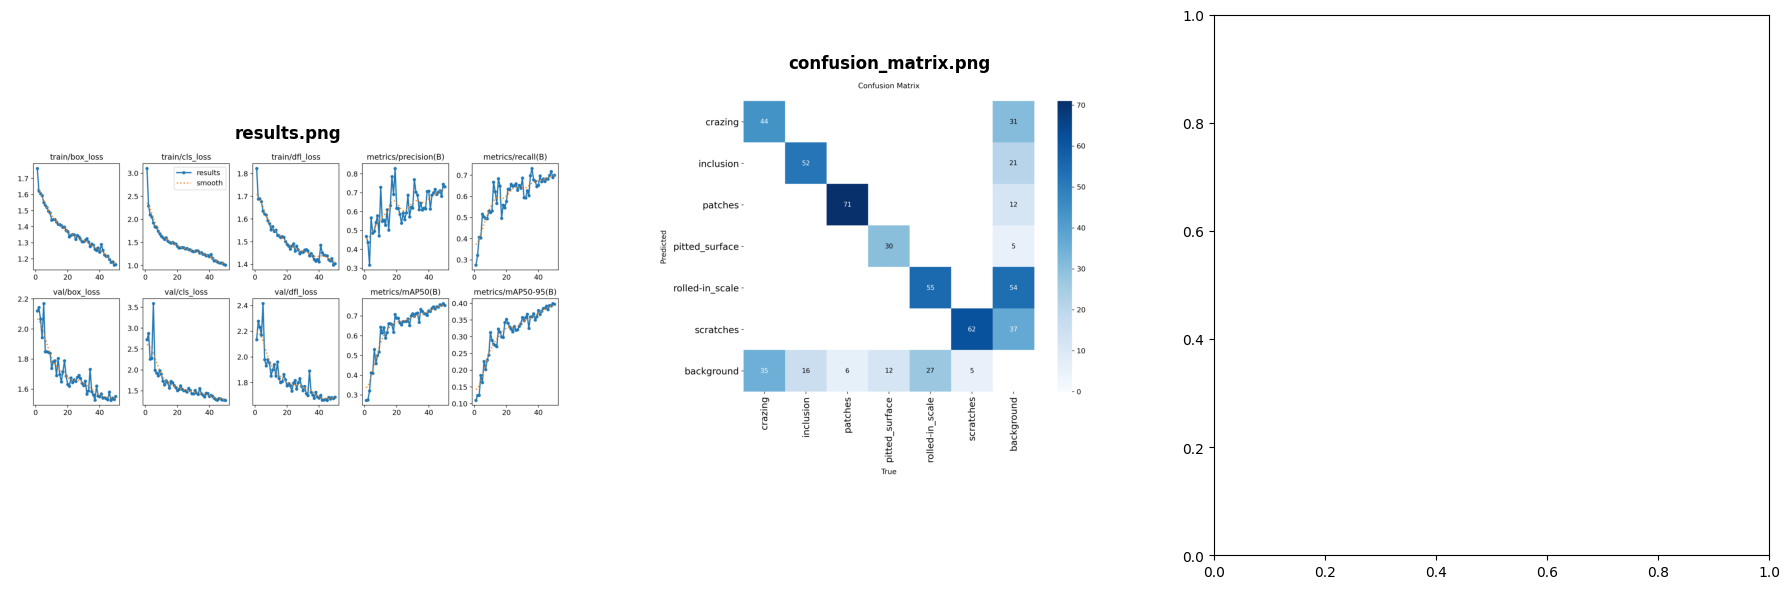


Running inference on sample test images...

0: 640x640 4 scratchess, 6.2ms
1: 640x640 3 crazings, 6.2ms
2: 640x640 1 patches, 2 pitted_surfaces, 6.2ms
3: 640x640 2 rolled-in_scales, 6.2ms
4: 640x640 6 scratchess, 6.2ms
5: 640x640 3 inclusions, 6.2ms
Speed: 3.6ms preprocess, 6.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


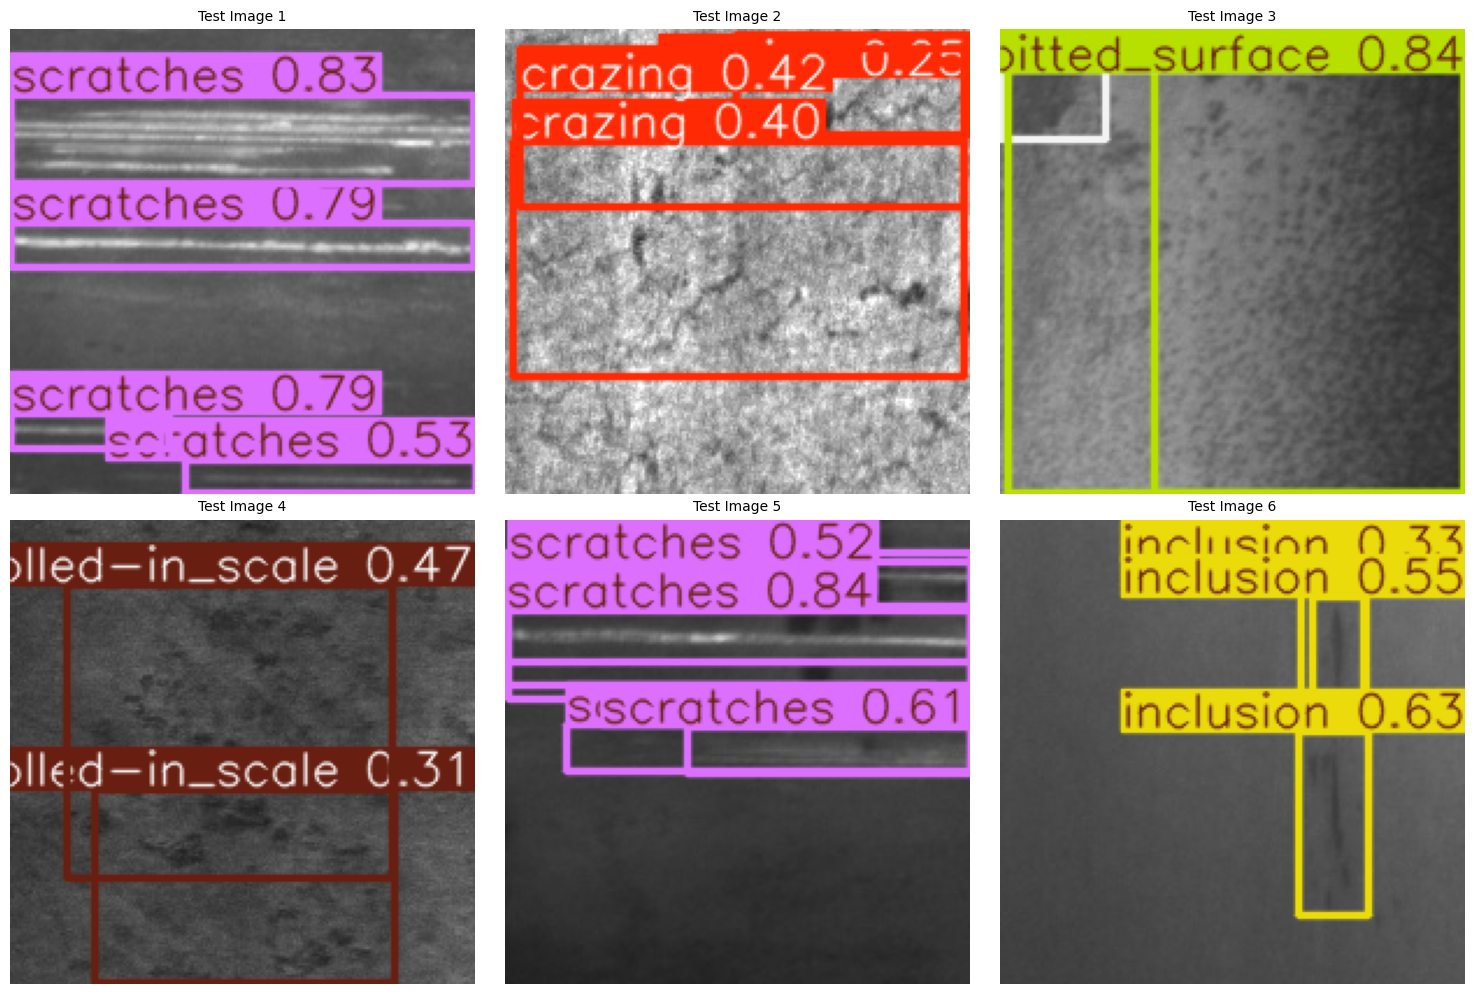

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

results_path = '/content/models/defect_detection'

# Display training results
images = ['results.png', 'confusion_matrix.png', 'PR_curve.png']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, img_name in enumerate(images):
    img_path = f"{results_path}/{img_name}"
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(img_name, fontsize=12, fontweight='bold')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Test predictions
print("\nRunning inference on sample test images...")
test_img_path = '/content/yolo_dataset/images/test'
test_images = [os.path.join(test_img_path, f) for f in os.listdir(test_img_path) if f.endswith(('.jpg', '.png'))]
sample_images = random.sample(test_images, min(6, len(test_images)))

best_model = YOLO('/content/models/defect_detection/weights/best.pt')
predictions = best_model.predict(sample_images, conf=0.25)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (img_path, result) in enumerate(zip(sample_images, predictions)):
    annotated = result.plot()
    axes[idx].imshow(annotated)
    axes[idx].set_title(f"Test Image {idx+1}", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()